*Автор: Петухов Дмитрий*<br />
*Дата: 17.04.2018*

<center>
<img src="../../img/jigsaw.png">

<center>
# Обнаружение и классификация недопустимых комментариев на Википедии

## Часть 1. Описание набора данных и признаков

Нередко обсуждение какой-либо темы на популярных сайтах скатывается во взаимные оскорбления и угрозы, что является недопустимым с точки зрения норм этики, морали и человеческого общения, а также деструктивно влияет на саму обсуждаемую тему. Люди просто перестают общаться, видя такое в комментариях. Данная проблема очень актуальна для Википедии. Каждая статья и её правки активно обсуждаются, и это общение бывает иногда не совсем корректным со стороны некоторых пользователей. Необходимо выявлять такие комментарии и удалять их, чтобы обсуждения были в рамках норм человеческого общения, не было переходов на личности и взаимных оскорблений.

### Источник данных

В проекте используются данные из соревнования на платформе Kaggle <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge">"Toxic Comment Classification Challenge"</a>. Компания <a href="https://jigsaw.google.com/">"Jigsaw"</a> (подразделение Google), занимающаяся исследованиями в области онлайн-общения пользователей, разместила <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data">данные</a>, содержащие корпус размеченных комментариев из Википедии.

### Цели и задачи

Необходимо определить с какой вероятностью каждый комментарий может быть отнесён к одному из следующих классов (целевая переменная):

1 - язвительный<br>
2 - издевательский<br>
3 - непристойная лексика<br>
4 - угроза<br>
5 - оскорбление<br>
6 - личная неприязнь<br>

В отличие от обычной постановки задачи классификации (multiclass), в данном случае один комментарий может с той или иной вероятностью принадлежать одновременно к нескольким классам (multilabel). Ценность такой задачи заключается в том, что в дальнейшем решение можно адаптировать под любую интернет-платформу и успешно использовать для пресечения оскорблений и перехода на личности.

### Описание набора данных

Представленные данные содержат два признака:

<b>'id'</b> - id комментария<br>
<b>'comment_text'</b> - текст комментария

Целевая переменная представлена шестью векторами-столбцами. Каждый из них содержит значения 0 или 1 в зависимости от того, принадлежит ли комментарий к данному классу или нет:

<b>'toxic'</b> - язвительный комментарий<br>
<b>'severe_toxic'</b> - издевательский комментарий<br>
<b>'obscene'</b> - комментарий содержит непристойную лексику<br>
<b>'threat'</b> - комментарий содержит угрозы<br>
<b>'insult'</b> - оскорбительный комментарий<br>
<b>'identity_hate'</b> - комментарий содержит признаки личной неприязни<br>

Следует заметить, что разметка данных осуществлялась разными людьми с использованием краудсорсинга, поэтому в той или иной степени классы целевой переменной имеют частично субъективный характер.

## Часть 2. Первичный анализ данных

### Импорт библиотек

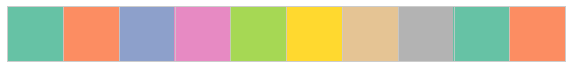

In [82]:
# базовые библиотеки
import pandas as pd 
import numpy as np

# sklearn библиотеки
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# NLP библиотеки
import string
import re    

# библиотеки визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#scipy
from scipy.sparse import csr_matrix, hstack
from scipy import sparse

#вспомогательные библиотеки
from PIL import Image
import pprint
import time
import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette("Set2", 10)
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

### Первичный анализ данных

Посмотрим на десять случайных объектов обучающего и тестового датасетов и выведем общее количество объектов в них. Также посмотрим на число уникальных значений в признаке id комментария.

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('Обучающая выборка содержит {} объект'.format(len(train)))
print('Число уникальных значений в признаке id: {}\n'.format(train.id.nunique()))
train.sample(10)

Обучающая выборка содержит 159571 объект
Число уникальных значений в признаке id: 159571



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79846,d5a63d9f11437638,Thank you for your corrections of Faddeeva fun...,0,0,0,0,0,0
81721,da953e10c38d2c6b,"""\nComment:\nFirst, Skinsmoke, you need to AGF...",0,0,0,0,0,0
22946,3ca6a237cd3ee4d8,"Anywhere will do, Nab. In any case, it will li...",0,0,0,0,0,0
45226,78eb49c72110c0e4,"""\nIf you look at Rick Norwood's quote, from t...",0,0,0,0,0,0
83810,e04eeb9d9642b015,Telling that you wouldn't answer my question. ...,1,0,0,0,0,0
92611,f7ab4a38748cd295,Updated some of the taxonomy; several that wer...,0,0,0,0,0,0
21829,39898887521be4a6,"""\n\n Hi there \n\nMy block expired a few hour...",0,0,0,0,0,0
147770,41742e4e5d580863,{{unblock|User did not know that his comments ...,0,0,0,0,0,0
15121,27efe6492b2daabf,gay boy \n\ni write to u to tell u that i know...,1,0,1,0,1,1
74079,c62eaa6abaeb3216,"""\n\nYou've got mail!\n\n'''''' (Chat • Count) """,0,0,0,0,0,0


In [52]:
print('Тестовая выборка содержит {} объекта'.format(len(test)))
print('Число уникальных значений в признаке id: {}'.format(test.id.nunique()))
test.sample(10)

Тестовая выборка содержит 153164 объекта
Число уникальных значений в признаке id: 153164


,id,comment_text,length
53706,593db6c03549d965,""", 5 September 2014 (UTC) \n\n :::What a silly...",386
71625,7750112a8c79aa15,"The front page has that ad, but there's also n...",213
41728,45479b7319eeae41,"yeah, they do need to open their eyes. such a...",407
134779,e15301a778414f32,":Znam, i u pravu si: Srbija treba da se ponosi...",1516
86692,90a97a8adfdf09dc,""" \n :there is a wiki article about Belus. If ...",1015
58439,6130c3167342777b,"fuck, fuck, fuck, fuck, fuck, fuck, fuck, fuck...",587
49494,5231829456b2e15a,"""]] • From the editor • General newsMembershi...",322
105395,aff36490472be85e,"""== Admin Noticeboard discussion beginning 3/2...",2849
72841,7950cf3d7a17d4d6,سخاوت \n حضرت انس رضی اللہ عنہ‘ سے روایت ہے ’’...,1021
53588,5909126ad3431c6e,""" \n :::Haha, no worries! I'm not seeing much ...",306


Как описывалось выше, тренировочные данные содержат два объясняющих признака и шесть вектор-столбцов целевой переменной. Аналогичная ситуация в тестовой выборке за исключением того, что в ней удалена целевая переменная. Всего - 159 571 комментарий в обучающей выборке и 153 164 комментариев в тестовой. Число уникальных значений в признаке id комментария в каждой выборке соответствует количеству объектов. Это хэш id комментария и он бесполезен в нашем случае. Удалим его. Таким образом, остается один единственный объясняющий признак - текст комментария. Следует обратить внимание ещё на два момента:
1. Как минимум в тестовой выборке присутствуют неанглоязычные комментарии. 
2. Текстовые данные сильно 'замусорены'

Теперь посмотрим, есть ли пропущенные значения в данных.

In [3]:
train.drop('id', axis=1, inplace=True)
null_count = train.isnull().sum(axis=0).reset_index()
null_count.columns = ['col_name', 'null_count']
null_count

,col_name,null_count
0,comment_text,0
1,toxic,0
2,severe_toxic,0
3,obscene,0
4,threat,0
5,insult,0
6,identity_hate,0


In [4]:
test.drop('id', axis=1, inplace=True)
null_count = test.isnull().sum(axis=0).reset_index()
null_count.columns = ['col_name', 'null_count']
null_count

,col_name,null_count
0,comment_text,0


Пропусков нет и это хорошая новость. Тренировочная и тестовая выборки имеют примерно одинаковое количество объектов.<br>
Посмотрим, как распределены классы целевой переменной в обучающей выборке. Следует помнить, что один объект может принадлежать к нескольким классам.

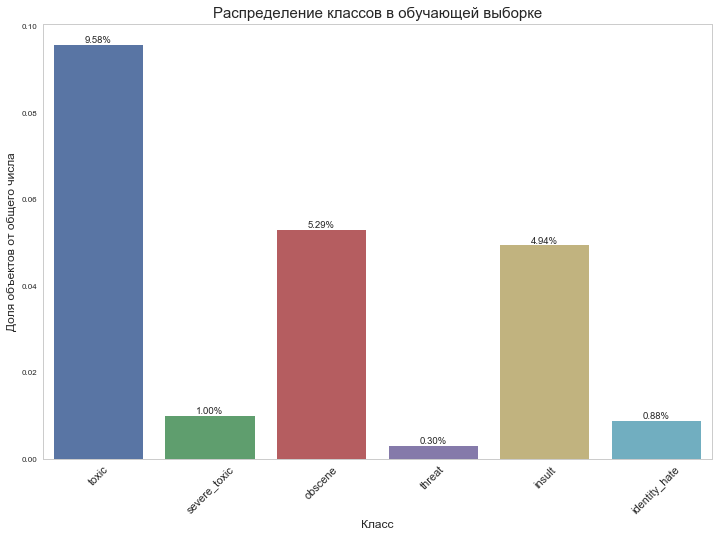

In [22]:
plt.figure(figsize=(12,8))
ax1 = sns.barplot(train.describe().loc['mean'].index, train.describe().loc['mean'])
plt.ylabel('Доля объектов от общего числа', fontsize=12)
plt.xlabel('Класс', fontsize=12)
plt.title('Распределение классов в обучающей выборке', fontsize=15)
plt.xticks(rotation=45, fontsize=11)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{0:.2f}%'.format(p.get_height()*100), (x.mean(), y), ha='center', va='bottom');

## Часть 3. Первичный визуальный анализ данных

Для дальнейшего визуального анализа добавим следующие признаки в обучающую выборку:<br>
<br>
<b>'clean'</b> - Нормальный комментарий (не принадлежит ни к одному из классов)<br>
<b>'class_sum'</b> - Число классов, к которым отнесён комментарий<br>

In [5]:
y_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_sum = train.loc[:,y_cols].sum(axis=1)
train['class_sum'] = class_sum
train['clean'] = (class_sum==0).astype(int)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,class_sum,clean
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,1


### Баланс классов

Далее посмотрим на число классов в обучающей выборке.

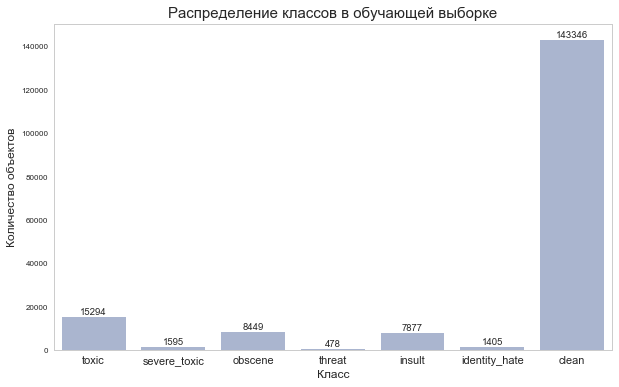

In [26]:
class_counts = train.loc[:, y_cols+['clean']].sum()
plt.figure(figsize=(10,6))
ax1 = sns.barplot(class_counts.index, class_counts, color=color[2], alpha=0.8)
plt.ylabel('Количество объектов', fontsize=12)
plt.xlabel('Класс', fontsize=12)
plt.title('Распределение классов в обучающей выборке', fontsize=15)
plt.xticks(fontsize=11)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

Видно, что в данных присутствует сильный дисбаланс классов. И это нормальная жизненная ситуация, подавляющее большинство людей предпочитают уважительное и конструктивное общение. Тем более на таком сайте как Википедия. Обратим внимание на то, что общая сумма объектов больше 153 164 и это тоже нормально, так как один и тот же комментарий может относится к нескольким классам.  

### Количество классов у одного комментария

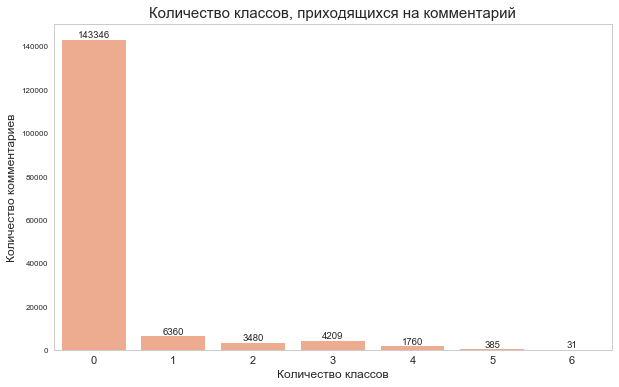

In [28]:
plt.figure(figsize=(10,6))
ax1 = sns.barplot(train.class_sum.value_counts().index, train.class_sum.value_counts(), color=color[1], alpha=0.8)
plt.ylabel('Количество комментариев', fontsize=12)
plt.xlabel('Количество классов', fontsize=12)
plt.title('Количество классов, приходящихся на комментарий', fontsize=15)
plt.xticks(fontsize=11)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

Нормальных комментариев, не относящихся ни к одному из классов ровно столько же, сколько и на предыдущем графике. Это очевидно. Комментариев, одновременно содержащих в себе язвительность, издевку, обсценную лексику, оскорбления, угрозы и личную неприязнь, то есть комментарий имеет признаки каждого класса, ничтожно мало - примерно 0.02%. Больше всего комментариев относится только к какому-то одному определенному классу. В то же время довольно большое число объектов относится к двум, трем и четырем классам одновременно. Последняя особенность довольно интересна, наверняка это близкие по "духу" классы. Проверим это предположение визуально, но сначала давайте посмотрим на пример комментария, содержащего признаки всех шести классов.

In [59]:
train[train.class_sum==6].reset_index(drop=True).loc[0,'comment_text']

"WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER."

Да, это действительно эталон недопустимого комментария. Кстати, на этом примере хороша видна одна особенность ругани в интернете - люди переходят на капслок. Возможно, это можно будет использовать в дальнейшем.

### Совместные появления классов в комментариях

In [67]:
heat = np.zeros((6,6))
for idx,col in enumerate(y_cols):
    if col=='severe_toxic':
        heat[idx,1:]=train[train[col]==1].groupby('class_sum')['class_sum'].count().values
    else:
        heat[idx,:]=train[train[col]==1].groupby('class_sum')['class_sum'].count().values

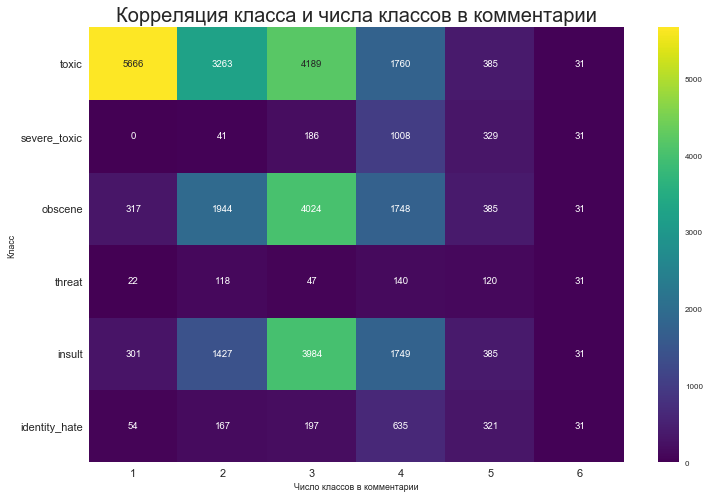

In [66]:
plt.figure(figsize=(12,8))
plt.title('Корреляция класса и числа классов в комментарии', fontsize=20)
ax = sns.heatmap(heat, cmap='viridis', fmt='.0f', xticklabels=[1,2,3,4,5,6], yticklabels=y_cols, annot=True)
ax.set(xlabel='Число классов в комментарии', ylabel='Класс')
ax.tick_params(labelsize=10)
plt.yticks(rotation=0, fontsize=11)
plt.xticks(fontsize=11);

Довольно интересные результаты. Во-первых, нет ни одного комментария, содержащего только один класс "severe_toxic". Во-вторых, подавляющее большинство комментариев с одним классом отнесены к "toxic". В-третьих, комментарии с признаками трех классов чаще всего относятся к: "toxic", "insult", "obscene". Это объяснимо, язвительность, мат и оскорбления всегда идут рука об руку. И еще одно наблюдение, которое непросто объяснить - классы "severe_toxic" и "identity_hate" встречаются чаще всего в комментариях с признаками четырех классов.</br> 
Посмотрим теперь на это под другим углом - как часто определенный класс появляется с другими классами.  

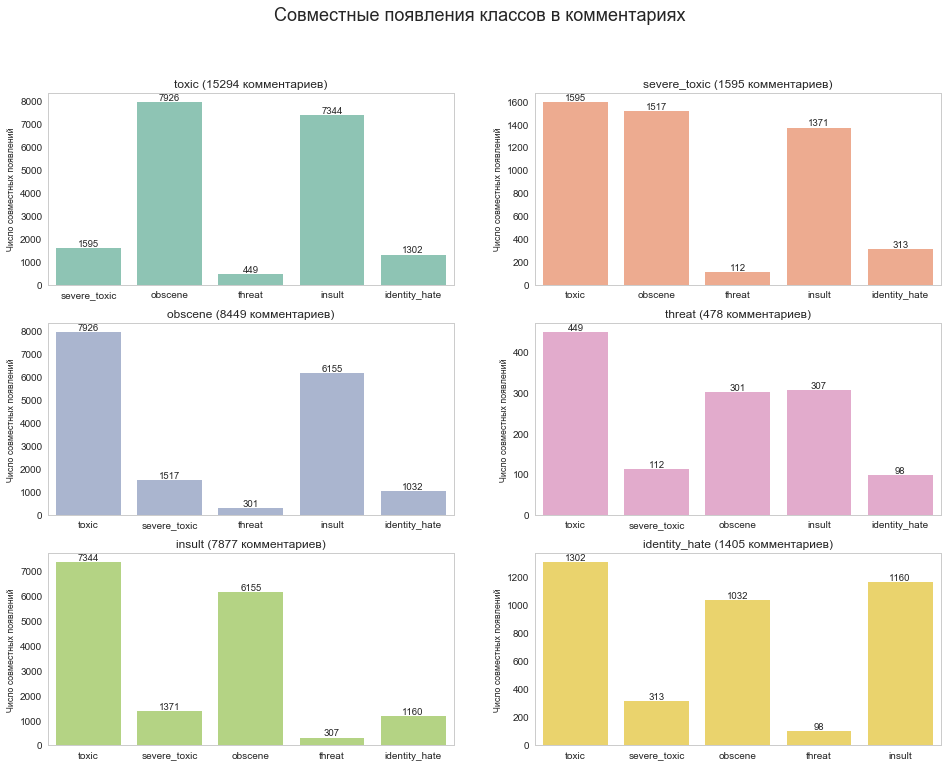

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.suptitle('Совместные появления классов в комментариях',fontsize = 18)

for idx, col in  enumerate(y_cols): 
    temp_list = y_cols[:]
    temp_list.remove(col)
    sub_series = train[train[col]==1].loc[:,temp_list].sum()
    ax1 = sns.barplot(sub_series.index, sub_series, color=color[idx], alpha=0.8, ax=axes[idx // 2][idx % 2])
    ax1.tick_params(labelsize=10)
    ax1.set_title(col+' ({} комментариев)'.format(train.loc[:,col].sum()), fontsize= 12)
    ax1.set_ylabel('Число совместных появлений')
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    
    ax1.grid(False)

Ситуация проясняется, комментарии с признаками класса "severe_toxic" абсолютно всегда размечаются и как "toxic". Более того, комментарии с признаками других классов тоже в подавляющем большинстве случаев размечаются и как "toxic".

### Длина комментария

Влияет ли как-то длина комментария (в символах) на нормальность или недопустимость комментария?

In [6]:
train['length'] = train['comment_text'].apply(len)
test['length'] = test['comment_text'].apply(len)

Посмотрим на комментарии с числом символов, к примеру, восемь:

In [76]:
train[train.length==8]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,class_sum,clean,length
109985,{{unbloc,0,0,0,0,0,0,0,1,8
118850,FUCK YOU,1,1,1,0,1,0,4,0,8
121074,you suck,1,0,1,0,1,0,3,0,8


Два комментария из трех определенно неприемлимы для нормального общения. Рассмотрим этот признак визуально более глобально. Для начала взглянем на распределение признака:

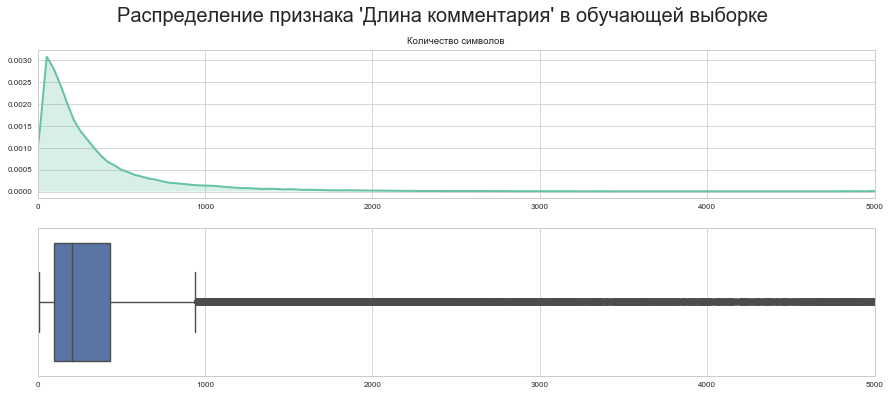

In [92]:
plt.figure(figsize=(15,6))
plt.suptitle("Распределение признака 'Длина комментария' в обучающей выборке",fontsize=20)

plt.subplot2grid((2,1),(0,0))
plt.xlim(0, train.length.max())
sns.distplot(train.length.values, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.title("Количество символов")

plt.subplot2grid((2,1),(1,0))
plt.xlim(0, train.length.max())
sns.boxplot(train.length.values);

Максимальная длина комментария в выборке - 5000 символов. Причем основная масса комментариев имеет длину менее 1000 символов. Посмотрим на распределение этого же признака в тестовой выборке.

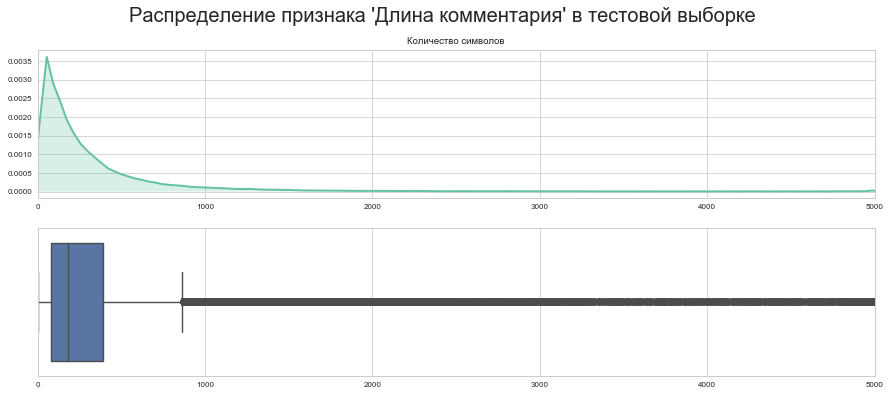

In [93]:
plt.figure(figsize=(15,6))
plt.suptitle("Распределение признака 'Длина комментария' в тестовой выборке",fontsize=20)

plt.subplot2grid((2,1),(0,0))
plt.xlim(0, test.length.max())
sns.distplot(test.length.values, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.title("Количество символов")

plt.subplot2grid((2,1),(1,0))
plt.xlim(0, test.length.max())
sns.boxplot(test.length.values);

Видим совершенно аналогичную ситуацию. Максимальная длина в 5000 символов говорит нам о том, что скорее всего была проведена дополнительная предобработка данных.<br>
Сравним длину комментариев в нормальных комментариях и неприемлимых. Рассмотрим только комментарии с длиной менее 1000 символов. 

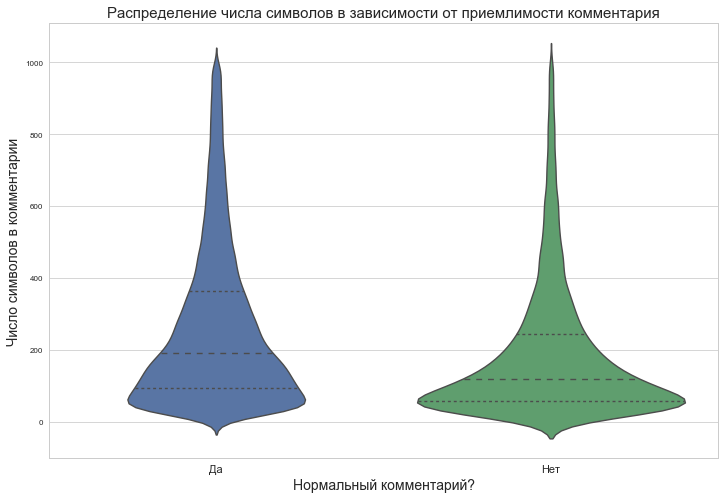

In [99]:
plt.figure(figsize=(12,8))
sns.violinplot(y=train['length'].loc[train['length']<1000],x=train.clean.map({0:'Нет', 1:'Да'}), data=train,split=True,inner="quart")
plt.xlabel('Нормальный комментарий?', fontsize=14)
plt.ylabel('Число символов в комментарии', fontsize=14)
plt.xticks(fontsize=11)
plt.title("Распределение числа символов в зависимости от приемлимости комментария", fontsize=15);

На первый взгляд, неприемлимые комментарии более короткие и имеют медианное значение около 100 символов, в то время как нормальные комментарии имеют медианное значение почти 200 символов. Вообще, резонно предположить, что недопустимые комментарии не будут очень длинными. Писать целый трактат, чтобы кого-то оскорбить это по меньшей мере странно. 

### Топ 10 слов в классах комментариев

Пришло время посмотреть, какие слова наиболее часто употребляют авторы недопустимых комментариев.

In [28]:
cv_train = CountVectorizer(ngram_range=(1, 1), max_features=1000, min_df=5, stop_words=stopwords.words('english'))
X_train = cv_train.fit_transform(train.comment_text.values).toarray()

top10_words_list=[]
top10_freq_list=[]
for col in y_cols:
    top10_words = []
    word_freq = X_train[train[col]==1].sum(axis=0)
    top10_list = word_freq.argsort()[-10:][::-1]
    for i in range(10):
        top10_words.append(list(cv_train.vocabulary_.keys())[list(cv_train.vocabulary_.values()).index(top10_list[i])])
    top10_words_list.append(top10_words)
    top10_freq_list.append(sorted(word_freq, reverse=True)[:10])

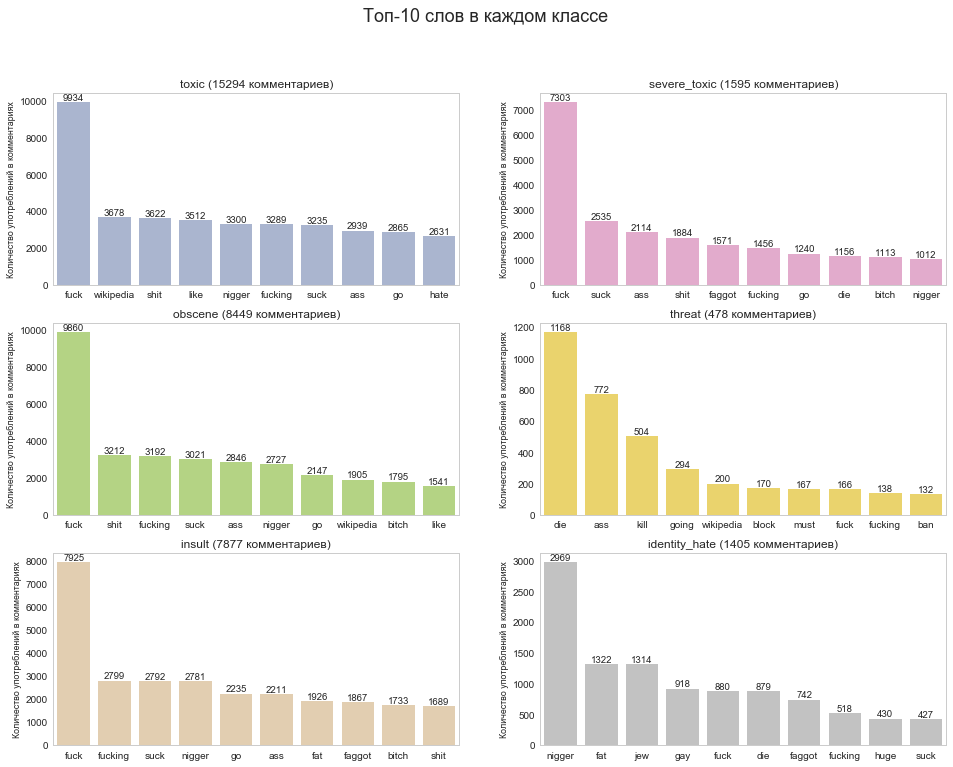

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.suptitle('Топ-10 слов в каждом классе',fontsize = 18)

for i, col in enumerate(y_cols): 
    temp_list = y_cols[:]
    temp_list.remove(col)
    ax1 = sns.barplot(top10_words_list[i], top10_freq_list[i], color=color[i+2], alpha=0.8, ax=axes[i // 2][i % 2])
    ax1.tick_params(labelsize=10)
    ax1.set_title(col+' ({} комментариев)'.format(train.loc[:,col].sum()), fontsize= 12)
    ax1.set_ylabel('Количество употреблений в комментариях')
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    
    ax1.grid(False)

Слово "fuck" лидирует во всех классах кроме комментариев, содержащих признаки угроз и личной неприязни. Харктерная особенность для этого слова в том, что в классе "severe_toxic" оно употребляется наиболее часто, в среднем 4 с лищним раза на один комментарий. Это много. В то же время слово "die" употребляется в среднем почти три раза в одном комментарии. В комментариях с признаками личной неприязни также есть свое слово-лидер - более двух раз на один комментарий. В то же время видно, что в топе есть и довольно нейтральные слова - wikipedia, like, go. Возможно, в дальнейшем их можно будет добавить в список стоп-слов.

## Часть 4. Инсайты, найденные зависимости

Подведем итог анализа данных:
1. В данных обнаружились неанглоязычные комментарии. Это усложняет задачу, но можно будет использовать как дополнительный признак.
2. Отсутствуют пропуски в данных
3. Максимальная длина комментария в обучающей и тестовой выборках - 5000 символов. В то время как подавляющее большинство комментариев имеет не более 1000 символов.
4. В данных сильный дисбаланс классов, это немного усложнит задачу, но в целом ничего страшного.
5. Оскорбительные комментарии в среднем относятся одновременно к одному, двум, трем и реже четырем классам. Довольно мало комментариев, содержащих в себе признаки пяти и тем более шести классов.
6. В процессе анализа данных обнаружился весьма хороший инсайт - нет ни одного комментария, относящегося только к одному классу "severe_toxic"
7. Наибольшее количество комментариев с одним классом отнесены к классу "toxic"
8. Комментарии имеющие признаки трех классов чаще всего относятся к: "toxic", "insult" и "obscene"
9. Классы "severe_toxic" и "identity_hate" встречаются чаще всего в комментариях с признаками четырех классов
10. Комментарии с признаками всех классов кроме "toxic" в подавляющем большинстве случаев размечаются и как "toxic". 
11. Медианное значение длины недопустимых комментариев меньше этого же значения нормальных комментариев примерно на 100 символов.
12. Некоторые классы имеют свои характерные особенности - наиболее часто употребляемые слова. Это может быть хорошим признаком в дальнейшем.

## Часть 5. Выбор метрики

В задачах бинарной классификации наиболее часто используются следующие метрики качества в зависимости от решаемой задачи:

- Доля правильных ответов (Accuracy)
- Полнота (Recall)
- Точность (Precision). 
- F-мера (F1-score). Среднее гармоническое точности и полноты.
- Функция логистических потерь (LogLoss)
- Площадь под ROC кривой (ROC-AUC)
- Коэффициент Джини (Normalized Gini)

Первые три метрики самые простые и оттого легко интерпретируемы, но имеют много минусов. И один из них - они совершенно не подходят для задач с сильным дисбалансом классов. Для нашей задачи наиболее подходят три последние метрики. Logloss сильно штрафует классификатор за уверенность в неверном ответе, так как максимизирует долю правильных ответов путем штрафа за неверные предсказания. Коэффициент Джини используется в основном в банковском секторе и страховании, это обусловлено тем, что в этой сфере в данных обычно сильнейший дисбаланс классов. Наиболее подходящая метрика для задачи - ROC-AUC. Она является отличным способом оценить предсказания вероятностей модели в целом, не привязываясь к конкретному порогу. 

Но мой индивидуальный проект подразумевает многоклассовую классификацию. В данном случае обычно используются два подхода:
- микроусреднение
- макроусреднение

В первом случае на расчет метрики качества влияет вклад каждого класса в зависимости от его размера. Во втором случае рассчитывается метрика качества для каждого класса и потом усредняется, таким образом значение метрики не зависит от мощности класса. Второй класс наиболее подходит для решаемой задачи. Подводя итог, в задаче будет использоваться метрика качетва ROC-AUC с макроусреднением по классам. Именно таким образом рассчитывался итоговый результат в соревновании на Kaggle.

## Часть 6. Выбор модели

Так как в задаче используются текстовые данные, то очевидно, что матрица признаков будет сильно разреженной и иметь большую размерность. Количество признаков будет исчисляться десятками тысяч. Алгоритмы на основе деревьев решений очень долго и не всегда хорошо обучаются на таких данных. В то же время линейные модели прекрасно обучаются на таких данных и показывают отличные результаты. Классическими моделями в подобных задачах классификации являются:

- LogisticRegression
- SGDClassifier
- Vowpal Wabbit

Дополнительным плюсом этих моделей является то, что они отлично интерпретируемы и имеют гиперпараметры, которые можно подбирать на кросс-валидации. Последние две модели используются преимущественно на гигабайтах и терабайтах данных, что объясняется очень просто, обе они используют стохастический градиентный спуск при оптимизации. Однако на практике эти модели показывают обычно более худшие результаты, чем логистическая регрессия. Хотя теоретически можно подобрать гиперпараметры этих моделей, чтобы они не уступали в качестве логистической регрессии. Данные индивидуального проекта относительно небольшие и использование логистической регрессии представляется наилучшим выбором в этом случае.

## Часть 7. Предобработка данных

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
train.drop(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
y_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Итак, изначально в данных присутстует только один признак - текст комментария.
Для преобразования текста будем использовать TfidfVectorizer из библиотеки Sklearn. TfidfVectorizer преобразует текст в матрицу TF-IDF. TF-IDF позволит оценить важность термина для какого-либо комментария относительно всех остальных комментариев. Принцип такой — если слово встречается в каком-либо комментарии часто, при этом встречаясь редко в остальных комментариях — это слово имеет большую значимость для этого комментария и соответственно классам, к которым этот комментарий относится. Слова, встречающиеся во многих комментариях, например, предлоги или междометия получат очень низкий вес TF-IDF (потому что часто встречаются во всех комментариях), а важные — высокий.
Теперь кратко о том, как считается TF-IDF. TF - это частотность термина, которая измеряет, насколько часто термин встречается в документе. Логично предположить, что в длинных документах термин может встретиться в больших количествах, чем в коротких. Поэтому применяют относительные — делят количество раз, когда нужный термин встретился в тексте, на общее количество слов в тексте. В этом основное отличие от CountVectorizer. IDF — это обратная частотность документов. Она измеряет непосредственно важность термина. То есть, когда мы считаем TF, все термины считаются равными по важности друг другу. Но вполне очевидно, что, например, предлоги встречаются очень часто, хотя практически не влияют на смысл текста. IDF считается как логарифм от общего количества документов, делённого на количество документов, в которых встречается термин. И в конце TF умножается на IDF.
Также, TfidfVectorizer имеет множество настроек:
- минимальное и максимальное количнсвто n-грамм для анализа
- максимальное число признаков
- минимальное и максимальное число документов, в которых должно встретиться слово, чтобы попасть в признаки.
- отключение расчета IDF
- логарифмическое масштабирование значения TF
- использование стоп-слов
- приведение всех символов к нижнему регистру
- нормализация токенов
и многие другие

И, пожалуй, один из основных плюсов - TfidfVectorizer имеет встроенный предобработчик текста, который задается в формате RegExp и его можно в любое время переопределить. По умолчанию удаляются знаки пунктуации, символы whitespace и берутся токены не меньше двух символов. Рассмотрим на примере случайного комментария, как TfidfVectorizer предобрабатывает текст.


In [242]:
text = [train.sample(1).iloc[0, 0]]
text

['"\n\nAlso, about it being my turn to argue back and forth and back and forth and back and forth and back and forth and back and forth with you: You HAVE NOT presented one counter argument against the article revision of yours needing a cleanup/POV check. εαίδεια* "']

Теперь обучим TfidfVectorizer и посмотрим на словарь. Так как комментарий один, то смысла в вычислении IDF нет, поэтому установим значение параметра use_idf в False.

In [251]:
cv = TfidfVectorizer(use_idf=False)
X = cv.fit_transform(text)
cv.get_feature_names()

['about',
 'against',
 'also',
 'and',
 'argue',
 'argument',
 'article',
 'back',
 'being',
 'check',
 'cleanup',
 'counter',
 'forth',
 'have',
 'it',
 'my',
 'needing',
 'not',
 'of',
 'one',
 'pov',
 'presented',
 'revision',
 'the',
 'to',
 'turn',
 'with',
 'you',
 'yours',
 'εαίδεια']

Видно, что TfidfVectorizer отлично справился с задачей. Матрица TF-IDF:

In [252]:
X.toarray()

array([[ 0.07881104,  0.07881104,  0.07881104,  0.70929937,  0.07881104,
         0.07881104,  0.07881104,  0.3940552 ,  0.07881104,  0.07881104,
         0.07881104,  0.07881104,  0.3940552 ,  0.07881104,  0.07881104,
         0.07881104,  0.07881104,  0.07881104,  0.07881104,  0.07881104,
         0.07881104,  0.07881104,  0.07881104,  0.07881104,  0.07881104,
         0.07881104,  0.07881104,  0.15762208,  0.07881104,  0.07881104]])

Сопоставим слова с их значениями TF-IDF (в данном случае только TF, так как комментарий один) и отсортируем по значениям TF в порядке убывания.

In [258]:
matrix_freq = np.asarray(X.sum(axis=0)).ravel()
dictionary = dict(zip(np.array(cv.get_feature_names()), matrix_freq))
pprint.pprint(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))

[('and', 0.70929936561519058),
 ('back', 0.39405520311955033),
 ('forth', 0.39405520311955033),
 ('you', 0.15762208124782012),
 ('about', 0.078811040623910061),
 ('against', 0.078811040623910061),
 ('also', 0.078811040623910061),
 ('argue', 0.078811040623910061),
 ('argument', 0.078811040623910061),
 ('article', 0.078811040623910061),
 ('being', 0.078811040623910061),
 ('check', 0.078811040623910061),
 ('cleanup', 0.078811040623910061),
 ('counter', 0.078811040623910061),
 ('have', 0.078811040623910061),
 ('it', 0.078811040623910061),
 ('my', 0.078811040623910061),
 ('needing', 0.078811040623910061),
 ('not', 0.078811040623910061),
 ('of', 0.078811040623910061),
 ('one', 0.078811040623910061),
 ('pov', 0.078811040623910061),
 ('presented', 0.078811040623910061),
 ('revision', 0.078811040623910061),
 ('the', 0.078811040623910061),
 ('to', 0.078811040623910061),
 ('turn', 0.078811040623910061),
 ('with', 0.078811040623910061),
 ('yours', 0.078811040623910061),
 ('εαίδεια', 0.078811040623

Слово "and" встречается чаще всего в комментарии и соответственно имеет наибольший вес. Слова "back", "forth" и "you" также встречаются более одного раза и имеют соответственно бОльшие веса. Слова, встречающиеся один раз в тексте имеют одинаковые веса. Но в вышеприведенном примере обрабатывается только один комментарий. В дальнейшем в словах, которые будут встречаться почти во всех комментариях, множитель IDF будет близок к нулю, что приведет к итоговому уменьшению значений весов у подобных слов. В этом вся прелесть и красота этой метрики. 

Преобразуем весь корпус комментариев в обучающей и тестовой выборках. Важно не забывать, что обучать TfidfVectorizer необходимо только на обучающей выборке, потому что в реальной жизни тестовые данные не известны. Если обучить на всем корпусе комментариев, то легко может получиться так, что бОльшие веса будут у слов, которые при обучении только на обучающей выборке таких значений весов бы не получили. Работать будем с униграмами и максимальным значением признаков 30 000.

In [268]:
%%time
cv = TfidfVectorizer(ngram_range=(1,1), max_features=30000)
X_train = cv.fit_transform(train.comment_text)
X_test = cv.transform(test.comment_text)

In [272]:
print('Размер обучающей матрицы: {}'.format(X_train.shape))
print('Размер тестовой матрицы: {}'.format(X_test.shape))

Размер обучающей матрицы: (159571, 30000)
Размер тестовой матрицы: (153164, 30000)


Выведем снова значения весов слов для комментария, который рассматривали выше:

In [306]:
idx = train[train.comment_text.str.contains('k. εαίδεια*')].index
col_idx = np.nonzero(X_train[idx,:].toarray())[1]
row = X_train[idx,:].toarray()
word_values = row[row!=0]
word_list = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(x)] for x in col_idx]
dictionary = dict(zip(np.array(word_list), np.array(word_values)))
pprint.pprint(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))

[('forth', 0.71427663669568542),
 ('back', 0.41481170432211578),
 ('and', 0.30270486894051679),
 ('needing', 0.15906926067719299),
 ('cleanup', 0.14589552936186356),
 ('counter', 0.13970896077978096),
 ('revision', 0.13911556703957428),
 ('turn', 0.1278394071081364),
 ('presented', 0.12660393072577314),
 ('argue', 0.12616600984056986),
 ('yours', 0.12222467494420114),
 ('argument', 0.11106066919580154),
 ('pov', 0.10192006732943935),
 ('check', 0.094427577735520532),
 ('against', 0.091518408204792553),
 ('being', 0.071791343884129652),
 ('you', 0.069744253143424473),
 ('also', 0.065467523927249388),
 ('one', 0.060512849107047545),
 ('about', 0.056486830521051259),
 ('my', 0.054638616024418489),
 ('article', 0.052002521699377816),
 ('with', 0.048682136021259599),
 ('have', 0.046095129164064733),
 ('not', 0.042424763502665649),
 ('it', 0.036831863194447395),
 ('of', 0.034666048687463459),
 ('to', 0.030428838647311218),
 ('the', 0.027960651201634806)]


Ситуация сильно изменилась. Видно, что часто используемые в комментариях (да и в обычной жизни) слова имеют минимальные веса. Обычно, имеет смысл удалять такие слова на этапе препроцессинга. У этих слов есть определенный термин - стоп-слова, и в библиотеке sklearn есть их предопределенный набор. Посмотрим сколько слов содержит стоп-лист:

In [313]:
len(ENGLISH_STOP_WORDS)

318

Добавим их и заново преобразуем корпус комментариев, для этого в TfidfVectorizer есть параметр "stop_words"

In [314]:
%%time
cv = TfidfVectorizer(ngram_range=(1,1), max_features=30000, stop_words='english')
X_train = cv.fit_transform(train.comment_text)
X_test = cv.transform(test.comment_text)

Wall time: 30.9 s


Снова посмотрим значения весов слов для вышерассматриваемого комментария:

In [315]:
idx = train[train.comment_text.str.contains('k. εαίδεια*')].index
col_idx = np.nonzero(X_train[idx,:].toarray())[1]
row = X_train[idx,:].toarray()
word_values = row[row!=0]
word_list = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(x)] for x in col_idx]
dictionary = dict(zip(np.array(word_list), np.array(word_values)))
pprint.pprint(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))

[('forth', 0.86728283145711915),
 ('needing', 0.19314370890823768),
 ('cleanup', 0.17714801423051588),
 ('counter', 0.16963621216221134),
 ('revision', 0.1689157067211316),
 ('turn', 0.15522406484055398),
 ('presented', 0.15372393533883699),
 ('argue', 0.1531922068099153),
 ('argument', 0.13485113007370333),
 ('pov', 0.12375250713042163),
 ('check', 0.11465504088857756),
 ('article', 0.063142054416042342)]


Великолепный результат - из 29 слов осталось 12 значимых. Остался еще один момент - линейные алгоритмы очень любят, чтобы признаки были отмасштабированы. Значение TF-IDF теоретически может быть гораздо больше 1, но в TfidfVectorizer по умолчанию используется L2 нормализация (параметр "norm"), при которой все значения весов масштабируются на интервал [0; 1]. Проверим:

In [320]:
print('Максимальное значение TF-IDF: {}'.format(X_train.max()))
print('Минимальное значение TF-IDF: {}'.format(X_train.min()))

Максимальное значение TF-IDF: 1.0
Минимальное значение TF-IDF: 0.0


Выше рассматривалось, что пропусков в данных и выбросов нет.

## Часть 8. Кросс-валидация и настройка гиперпараметров модели

В третьей части проекта было показано, что целевая переменная имеет сильный дисбаланс по всем классам. Для кросс-валидации необходимо будет разбить обучающие данные таким образом, чтобы в каждом фолде было примерно одинаковое количество каждого из шести классов. Таким образом, необходимо провести стратифицированный отбор объектов из обучающей выборки по каждому вектору целевой переменной, чтобы в итоговых фолдах было примерно одинаковое количество всех шести классов. В sklearn не реализована такая возможность, поэтому внизу приведена кастомная функция для стратифицированной разбивки данных по фолдам. В данной реализации seed указывать нет необходимости, так как данная несложная задача оптимизации имеет аналитическое решение. Функция принимает на вход векторы целевой переменной (матрицу), количество необходимых фолдов и возвращает индексы объектов для каждого фолда. 

In [3]:
def multi_label_split(y, folds=3):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
    return index_list, fold_dist

Реализуем трехуровневую кросс-валидацию.

In [4]:
index_list, fold_dist = multi_label_split(y=y_train, folds=3)

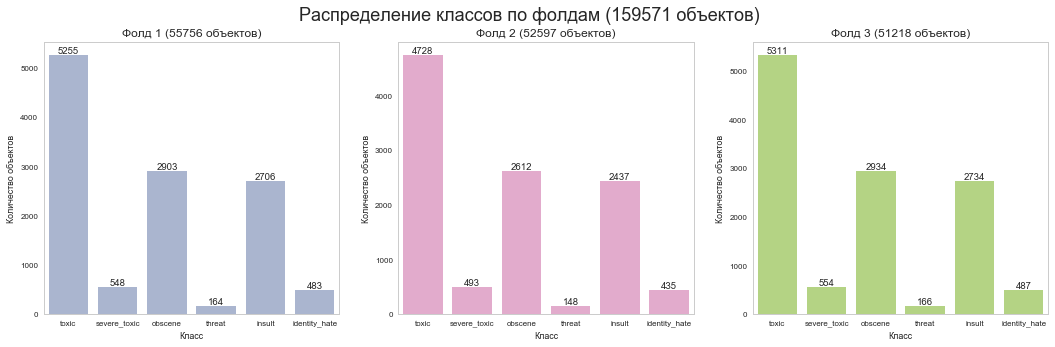

In [7]:
plt.figure(figsize=(18,5))
plt.suptitle('Распределение классов по фолдам ({} объектов)'.format(len(train)),fontsize = 18)

for i, fold in enumerate(fold_dist): 
    plt.subplot(131+i)
    ax1 = sns.barplot(y_cols, fold, color=color[i+2], alpha=0.8)
    ax1.set_title('Фолд {} ({} объектов)'.format(i+1, len(y_train[index_list[i]])), fontsize= 12)
    ax1.set_ylabel('Количество объектов')
    ax1.set_xlabel('Класс')
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    ax1.grid(False);

Видно, что количество объектов и распределение классов во всех фолдах примерно одинаковое.
Теперь необходимо реализовать функцию кросс-валидации. Здесь стоит остановиться на одном важном моменте. Необходимо будет заново преобразовывать обучающую и валидационную выборки в матрицы TF-IDF при каждом проходе по фолдам, чтобы избежать утечки данных и как следствие некорректного значения на кросс-валидации. На вход функция будет принимать следующие параметры:
1. Модель для обучения и прогнозов
2. Исходную обучающую выборку (это необходимо для того, чтобы в дальнейшем построить кривые обучения и валидации)
3. Целевую переменную
4. Список индексов фолдов, полученный в ранее реализованной функции multi_label_split. При каждом проходе один фолд будет выполнять роль тестовой выборки, а два других - обучающей.
5. Параметры TfidfVectorizer
6. Параметр verbose - отображать или нет значения ROC-AUC классов в каждом фолде

На выходе функция будет возвращать среднее значение ROC-AUC значений по фолдам. На каждом проходе модель обучается шесть раз на каждом классе целевой переменной и каждый раз рассчитывается значение ROC-AUC для прогнозов по каждому классу, потом эти шесть значений усредняются (макроусреднение, как описывалось выше). 

In [8]:
def multi_label_cv(model, X, y, index_list, tfidf_params, verbose=True, add_feats=False):
    roc_auc_folds = []
    for i in range(3):
        print('========== FOLD {} =========='.format(i+1))
        X_tr = X.values[list(set(range(len(y)))-set(index_list[i])), :]
        y_tr = y[list(set(range(len(y)))-set(index_list[i])), :]
        X_val, y_val = X.values[index_list[i], :], y[index_list[i], :]

        cv = TfidfVectorizer(**tfidf_params)
        X_tr_csr = cv.fit_transform(X_tr.ravel())
        X_val_csr = cv.transform(X_val.ravel())

        roc_auc_scores = []
        preds_val = np.zeros((y_val.shape[0], 6))
        for i in range (6):
            print('class: {}, '.format(y_cols[i]), end=" ")
            model.fit(X_tr_csr, y_tr[:,i])
            preds_val[:,i] = model.predict_proba(X_val_csr)[:,1]
            roc_auc_scores.append(roc_auc_score(y_val[:,i], preds_val[:,i]))
            if verbose:
                print('ROC-AUC score: ', roc_auc_scores[i])

        print('mean ROC-AUC score by fold: ', np.mean(roc_auc_scores))
        roc_auc_folds.append(np.mean(roc_auc_scores))

    print('\nMEAN ROC-AUС score: ', np.mean(roc_auc_folds))

### Гиперпараметры модели

Логистическая регрессия (LogisticRegression) имеет следующие основные гиперпараметры:
1. <b>solver</b> ("newton-cg", "lbfgs", "liblinear", "sag", "saga") – алгоритм, который используется для решения задачи оптимизации. Для небольших данных обычно используется "liblinear". Остальные алгоритмы используются либо для больших данных, либо для решения задачи оптимизации в случае, когда целевая переменная представляет собой один мультиклассовый вектор (multinomial). В нашем случае используется схема мультиклассовой классификации one-versus-rest, для которой идельно подходит алгоритм liblinear.
2. <b>C</b> - коэффициент регуляризации. Чем меньше значение данного коэффициента, тем сильнее регуляризация. Значение данного гиперпараметра будет настроено позже, после после создания новых признаков. В данной части берется значение по умолчанию, равное единице.
3. <b>penalty</b> (L1 или L2) - тип регуляризации. По умолчанию используется L2-регуляризация, в то время, как нам, возможно, будет полезен L1-тип регуляризации. Этот гиперпараметр также будет настроен на кросс-валидации после построения новых признаков.
4. <b>class_weight</b> - очень важный гиперпараметр в контексте решения данной задачи. Используется при дисбалансе классов. Сразу выставим его значение True.
5. <b>random_state</b> - используется для воспроизводимости результатов. Укажем значение равное 1.
6. <b>dual</b> - прямая или дуальная задача оптимизации. Иммет смысл использовать только если количество признаков превышает количество объектов. 
7. <b>tol, max_iter</b> - параметры раннего останова алгоритма оптимизации, используются только в алгоритмах  newton-cg, sag и lbfgs
8. <b>multi_class</b> - multinominal или ovr. В данной задаче реализуется схема мультиклассовой классификации one-versus-rest, что соответствует значению по умолчанию
9. <b>fit_intercept</b> - определяет добавлять ли константный коэффициент. По умолчанию True, что соответствует задаче.

In [9]:
lr_params={'C': 1.0,
           'solver': 'liblinear', 
           'penalty': 'l2',
           'class_weight': 'balanced',
           'random_state': 1,
           }

lr = LogisticRegression(**lr_params)

tfidf_params={'ngram_range': (1,1),
              'max_features': 30000, 
              'stop_words': 'english'
              }

In [10]:
multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params)

========== FOLD 1 ==========
class: toxic,  ROC-AUC score:  0.969689842884
class: severe_toxic,  ROC-AUC score:  0.983025789265
class: obscene,  ROC-AUC score:  0.98505537548
class: threat,  ROC-AUC score:  0.974356450217
class: insult,  ROC-AUC score:  0.976208958624
class: identity_hate,  ROC-AUC score:  0.973272248994
mean ROC-AUC score by fold:  0.976934777577
========== FOLD 2 ==========
class: toxic,  ROC-AUC score:  0.968722476482
class: severe_toxic,  ROC-AUC score:  0.985185250501
class: obscene,  ROC-AUC score:  0.983750289712
class: threat,  ROC-AUC score:  0.984659164398
class: insult,  ROC-AUC score:  0.976296102779
class: identity_hate,  ROC-AUC score:  0.973545810201
mean ROC-AUC score by fold:  0.978693182346
========== FOLD 3 ==========
class: toxic,  ROC-AUC score:  0.968087011539
class: severe_toxic,  ROC-AUC score:  0.982360569329
class: obscene,  ROC-AUC score:  0.983628748746
class: threat,  ROC-AUC score:  0.98238743582
class: insult,  ROC-AUC score:  0.976178371

Алгоритм показывает довольно хорошие результаты.
В данной части была реализована модель кросс-валидации и выбраны гиперпараметры модели LogisticRegression. Значения параметров "С" и "penalty" будут подобраны на кросс-валидации в следующей части после создания признаков.

## Часть 9. Создание новых признаков и описание этого процесса

Ранее выдвигались следующие предположения:
1. Нормальные комментарии в среднем длиннее оскорбительных, поэтому можно создать признак "длина комментария в символах"
2. Довольно часто в реальной жизни при хамском общении люди часто используют капслок в комментариях. Есть даже такой термин "кричать капслоком". На основании этого можно посчитать частоту символов в верхнем регистре относительно общего числа символов в комментарии. Как таковое абсолютное значение числа символов в верхнем регистре будет бессмысленно из-за того, что комментарии имеют разную длину от 1 до 5000 символов.
3. Очевидно, что в интернете, когда люди оскорбляют кого-то, то используют восклицательные знаки (аналогично крику в реальной жизни). На основании данного предположения можно посчитать частоту восклицательных знаков в тексте комментария.
4. Можно выдвинуть гипотезу, что комментарии, содержащие символ \*, скорее всего оскорбительного характера. Обычно люди не употребляют этот символ при написании текста, но если собираются написать неприличное слово, то какую-нибудь букву в нем скорее всего заменят на этот символ. Либо пользователь догадывается или знает, что комментарии автоматически модерируются и специально поставит \*, чтобы выйти из паттерна.
5. Признаковое пространство слов. Можно будет подобрать на кросс-валидации оптимальное число признаков , дающее лучший результат на обучении.

После создания новых признаков необходимо будет подобрать гиперпараметры модели LogisticRegression

### Признак "Длина комментария в символах"

Создадим отдельный датафрейм, который в дальнейшем будет содержать дополнительные добавляемые признаки и создадим признак "длина комментария в символах"

In [11]:
feats_train = pd.DataFrame()
feats_train['length'] = train['comment_text'].apply(len)

In [12]:
feats_train.head()

,length
0,264
1,112
2,233
3,622
4,67


Значения признака находятся в интервале [1, 5000], как было показано ранее. Это не подходит для модели LogisticRegression, поэтому значения необходимо будет отмасштабировать. Причем делать это необходимо будет при каждом проходе по фолдам, чтобы не было утечки данных. Для этого доработаем функцию кросс-валидации. В ней добавятся еще два параметра:
- X_f - датафрейм с дополнительными признаками. 
- scale_cols - масштабируемые признаки

Датафрейм с дополнительными признаками также разбивается по индексам и необходимые признаки масштабируются. Далее матрицы объединяются с помощью функции hstack.

In [13]:
def multi_label_cv(model, X, y, index_list, tfidf_params, X_f, scale_cols, verbose=True):
    roc_auc_folds = []
    for fold in range(3):
        if verbose:
            print('========== FOLD {} =========='.format(fold+1))
        trn_idx = list(set(range(len(y)))-set(index_list[fold]))
        X_tr = X.values[trn_idx, :]
        y_tr = y[trn_idx, :]
        X_val, y_val = X.values[index_list[fold], :], y[index_list[fold], :]
        X_tr_f = X_f.iloc[trn_idx, :]
        X_val_f = X_f.iloc[index_list[fold], :]

        cv = TfidfVectorizer(**tfidf_params)
        X_t_csr = cv.fit_transform(X_tr.ravel())
        X_v_csr = cv.transform(X_val.ravel())  
        
        scaler = StandardScaler()
        X_tr_f[scale_cols] = scaler.fit_transform(X_tr_f[scale_cols].values)
        X_val_f[scale_cols] = scaler.transform(X_val_f[scale_cols].values)
        
        X_tr_csr = hstack([X_t_csr, X_tr_f])
        X_val_csr = hstack([X_v_csr, X_val_f])

        roc_auc_scores = []
        preds_val = np.zeros((y_val.shape[0], 6))
        for i in range (6):
            model.fit(X_tr_csr, y_tr[:,i])
            preds_val[:,i] = model.predict_proba(X_val_csr)[:,1]
            roc_auc_scores.append(roc_auc_score(y_val[:,i], preds_val[:,i]))
            if verbose:
                print('class: {}, '.format(y_cols[i]), end=" ")
                print('ROC-AUC score: ', roc_auc_scores[i])
        if verbose:
            print('mean ROC-AUC score by fold: ', np.mean(roc_auc_scores))
        roc_auc_folds.append(np.mean(roc_auc_scores))

    print('\nMEAN ROC-AUС score: {:.6f}\n'.format(np.mean(roc_auc_folds)))
    return np.mean(roc_auc_folds)

In [14]:
%%time
_ = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
               scale_cols=['length'], verbose=False)


MEAN ROC-AUС score: 0.978121

Wall time: 1min 59s


Значения ROC-AUC улучшились. Добавим теперь признак "Доля символов в верхнем регистре"

### Признак "Доля символов в верхнем регистре в комментарии"

Для подсчета доли символов в верхнем регистре удобно воспользоваться библиотекой регулярных выражений re:

In [16]:
feats_train['upper_case_ratio'] = train['comment_text'].apply(lambda x: \
                                                              len(re.findall(r'[A-Z]',x))/(len(re.findall(r'[A-Za-z]',x))+1))

In [17]:
feats_train.head()

,length,upper_case_ratio
0,264,0.083333
1,112,0.108108
2,233,0.021390
3,622,0.022587
4,67,0.039216


Очевидно, что данные значения всегда будут меньше или равны единице, следовательно масштабировать данный признак не надо.

In [18]:
%%time
_ = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
               scale_cols=['length'], verbose=False)


MEAN ROC-AUС score: 0.978634

Wall time: 2min 26s


0.978633559723737

Значение метрики снова улучшилось.

### Признак "Доля восклицательных знаков"

In [19]:
feats_train['exclamation_point'] = train['comment_text'].apply(lambda x: x.count('!')/len(x))

In [20]:
feats_train.head()

,length,upper_case_ratio,exclamation_point
0,264,0.083333,0.000000
1,112,0.108108,0.008929
2,233,0.021390,0.000000
3,622,0.022587,0.000000
4,67,0.039216,0.000000


В данном случае значения также всегда будут меньше или равны единице, следовательно масштабировать данный признак не надо.

In [21]:
%%time
_ = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
               scale_cols=['length'], verbose=False)


MEAN ROC-AUС score: 0.978663

Wall time: 2min 32s


0.97866310942165979

Значение метрики ROC-AUC на кросс-валидации в очередной раз улучшилось.

### Признак "Символ * в комментарии"

Данный признак будет бинарный:<br><br>
1 - в комментарии присутствует символ\*<br>
0 - в комментарии отсутствует символ \*

In [22]:
feats_train['asterix'] = train['comment_text'].apply(lambda x: 1 if x.count('*')>0 else 0)

In [23]:
feats_train.head()

,length,upper_case_ratio,exclamation_point,asterix
0,264,0.083333,0.000000,0
1,112,0.108108,0.008929,0
2,233,0.021390,0.000000,0
3,622,0.022587,0.000000,0
4,67,0.039216,0.000000,0


In [24]:
%%time
_ = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
               scale_cols=['length'], verbose=False)


MEAN ROC-AUС score: 0.978832

Wall time: 2min 41s


0.97883183791355799

Гипотеза оказалась верна и значение средней величины ROC-AUC на кросс-валидации улучшилось.

### Настройка параметров TfidfVectorizer

**Признаковое пространство**<br>
В цикле будем вызывать функцию кросс-валидации, передавая в TfidfVectorizer различные значения параметра 'max_features' (максимальное число признаков-слов). Параметр будет принимать значения от 10 000 до 100 000 с шагом 10 000.

In [25]:
%%time
scores=[]
for num_feats in range(10000,110000,10000):
    tfidf_params={'ngram_range': (1,1),
                  'max_features': num_feats, 
                  'stop_words': 'english'
                  }
    print('max_features = {}'.format(num_feats))
    score = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
                   scale_cols=['length'], verbose=False)    
    scores.append(score)

max_features = 10000

MEAN ROC-AUС score: 0.976762

max_features = 20000

MEAN ROC-AUС score: 0.978377

max_features = 30000

MEAN ROC-AUС score: 0.978832

max_features = 40000

MEAN ROC-AUС score: 0.979262

max_features = 50000

MEAN ROC-AUС score: 0.979361

max_features = 60000

MEAN ROC-AUС score: 0.979364

max_features = 70000

MEAN ROC-AUС score: 0.979526

max_features = 80000

MEAN ROC-AUС score: 0.979568

max_features = 90000

MEAN ROC-AUС score: 0.979595

max_features = 100000

MEAN ROC-AUС score: 0.979593

Wall time: 27min 2s


Построим график зависимости значения ROC-AUC от числа признаков-слов.

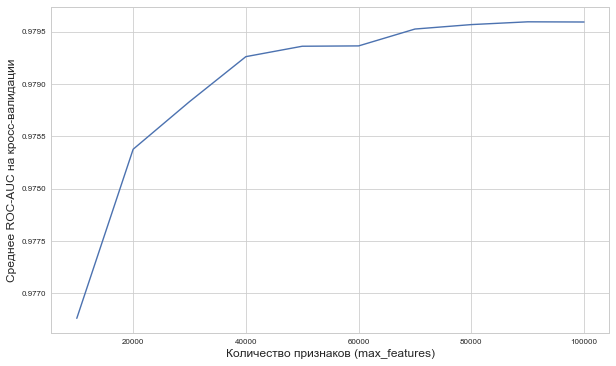

In [27]:
plt.figure(figsize=(10,6))
plt.plot(list(range(10000,110000,10000)), scores)
plt.ylabel('Среднее ROC-AUC на кросс-валидации', fontsize=12)
plt.xlabel('Количество признаков (max_features)', fontsize=12);

Хорошо видно, что примерно при 80 000 признаков значение выходит на плато. В дальнейшем будем использовать данное значение для параметра max_features.

**Параметр sublinear_tf**<br>
Данный параметр преобразует значение TF в логарифмической шкале и рассчитывается по формуле tf = 1 + log(tf), если tf>0. Смысл этого параметра в том, что значение TF быстро растет при маленьких значениях (слово нечасто встречается в документе) и медленно - при больших значениях (слово часто встречается в документе). По умолчанию равен False. Также в цикле будем вызывать функцию кросс-валидации, передавая в TfidfVectorizer различные значения параметра.

In [28]:
%%time
scores=[]
for param in [True, False]:
    tfidf_params={'ngram_range': (1,1),
                  'max_features': 80000, 
                  'stop_words': 'english',
                  'sublinear_tf': param
                  }
    print('sublinear_tf = {}'.format(param))
    score = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
                   scale_cols=['length'], verbose=False)    
    scores.append(score)

sublinear_tf = True

MEAN ROC-AUС score: 0.980552

sublinear_tf = False

MEAN ROC-AUС score: 0.979568

Wall time: 5min 20s


При сглаживании значения TF значение ROC-AUC ощутимо повышается.
Зафиксируем окончательные значения параметров TfidfVectorizer:

In [29]:
tfidf_params={'ngram_range': (1,1),
              'max_features': 80000, 
              'stop_words': 'english',
              'sublinear_tf': True
                  }

### Настройка гиперпараметров модели

Осталось подобрать значения гиперпараметров модели. Аналогично в цикле будем вызывать функцию кросс-валидации, передавая в неё модель с различными параметрами. Параметры TfidfVectorizer уже подобраны и их не меняем. Для начала сравним значения при рахных регуляризациях (l1 и l2), а также сделаем предварительную оценку лучшего значения коэффициента регуляризации. Более точно лучшее значение выберем в следующей части при построении кривых валидации.

In [30]:
%%time
scores=[]
for i in ['l2', 'l1']:
       
    lr_params={'C': 1.0,
           'solver': 'liblinear', 
           'penalty': i,
           'class_weight': 'balanced',
           'random_state': 1,
           }
    print('penalty = {}'.format(i))
    lr = LogisticRegression(**lr_params)
    score = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
                   scale_cols=['length'], verbose=False)    
    scores.append(score)

penalty = l2

MEAN ROC-AUС score: 0.980552

penalty = l1

MEAN ROC-AUС score: 0.976983

Wall time: 5min 10s


Результаты при  использовании l2-регуляризации значительно лучше

In [32]:
%%time
scores=[]

for i in [0.5, 1.0, 2.0, 3.0, 4.0]:
        
    lr_params={'C': i,
           'solver': 'liblinear', 
           'penalty': 'l2',
           'class_weight': 'balanced',
           'random_state': 1,
           }
    print('С = {}'.format(i))
    lr = LogisticRegression(**lr_params)
    score = multi_label_cv(lr, train, y_train, index_list, tfidf_params=tfidf_params, X_f=feats_train, 
                   scale_cols=['length'], verbose=False)    
    scores.append(score)

С = 0.5

MEAN ROC-AUС score: 0.980485

С = 1.0

MEAN ROC-AUС score: 0.980552

С = 2.0

MEAN ROC-AUС score: 0.979900

С = 3.0

MEAN ROC-AUС score: 0.979159

С = 4.0

MEAN ROC-AUС score: 0.978459

Wall time: 13min 57s


Построим график зависимости значения ROC-AUC от значения коэффициента регуляризации.

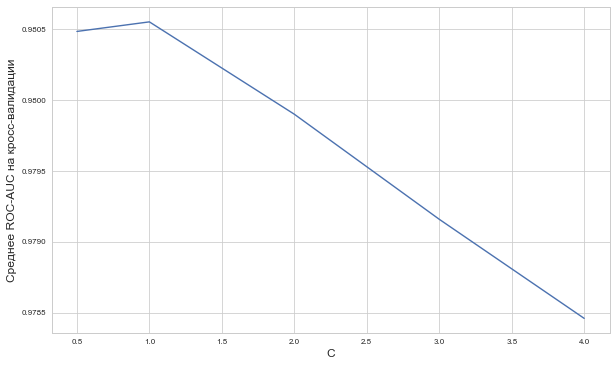

In [34]:
plt.figure(figsize=(10,6))
plt.plot([0.5, 1.0, 2.0, 3.0, 4.0], scores)
plt.ylabel('Среднее ROC-AUC на кросс-валидации', fontsize=12)
plt.xlabel('С', fontsize=12);

Лучшее значение коэффициента регуляризации С предположительно лежит в интервале (0.5. 2.0)

## Часть 10. Построение кривых валидации и обучения

Модифицируем функцию кросс-валидации так, чтобы она возвращала следующие значения:
- среднее значение ROC-AUC на обучающей выборке
- среднее значение ROC-AUC на тестовой выборке
- стандартное отклонение значения ROC-AUC на обучающей выборке
- стандартное отклонение значения ROC-AUC на тестовой выборке

In [38]:
def multi_label_cv(model, X, y, index_list, tfidf_params, X_f, scale_cols, verbose=True):
    roc_auc_folds_val = []
    roc_auc_folds_tr = []
    for fold in range(3):
        if verbose:
            print('========== FOLD {} =========='.format(fold+1))
        trn_idx = list(set(range(len(y)))-set(index_list[fold]))
        X_tr = X.values[trn_idx, :]
        y_tr = y[trn_idx, :]
        X_val, y_val = X.values[index_list[fold], :], y[index_list[fold], :]
        X_tr_f = X_f.iloc[trn_idx, :]
        X_val_f = X_f.iloc[index_list[fold], :]

        cv = TfidfVectorizer(**tfidf_params)
        X_t_csr = cv.fit_transform(X_tr.ravel())
        X_v_csr = cv.transform(X_val.ravel())  
        
        scaler = StandardScaler()
        X_tr_f[scale_cols] = scaler.fit_transform(X_tr_f[scale_cols].values)
        X_val_f[scale_cols] = scaler.transform(X_val_f[scale_cols].values)
        
        X_tr_csr = hstack([X_t_csr, X_tr_f])
        X_val_csr = hstack([X_v_csr, X_val_f])

        roc_auc_scores_val = []
        roc_auc_scores_tr = []
        preds_val = np.zeros((y_val.shape[0], 6))
        preds_tr = np.zeros((y_tr.shape[0], 6))
        for i in range (6):
            model.fit(X_tr_csr, y_tr[:,i])
            preds_val[:,i] = model.predict_proba(X_val_csr)[:,1]
            preds_tr[:,i] = model.predict_proba(X_tr_csr)[:,1]
            roc_auc_scores_val.append(roc_auc_score(y_val[:,i], preds_val[:,i]))
            roc_auc_scores_tr.append(roc_auc_score(y_tr[:,i], preds_tr[:,i]))
            if verbose:
                print('class: {}, '.format(y_cols[i]), end=" ")
                print('ROC-AUC score: ', roc_auc_scores[i])
        if verbose:
            print('mean ROC-AUC score by fold: ', np.mean(roc_auc_scores))
        roc_auc_folds_val.append(np.mean(roc_auc_scores_val))
        roc_auc_folds_tr.append(np.mean(roc_auc_scores_tr))

    print('\nMEAN ROC-AUС score: {:.6f}\n'.format(np.mean(roc_auc_folds_val)))
    return np.mean(roc_auc_folds_tr), np.std(roc_auc_folds_tr), np.mean(roc_auc_folds_val), np.std(roc_auc_folds_val)

Вспомогательные функции для отрисовки кривых валидации и обучения

In [68]:
def plot_validation_curves(param_values, train_mu, train_std, valid_mu, valid_std):
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, np.array(train_mu) - np.array(train_std), 
                     np.array(train_mu) + np.array(train_std), edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, np.array(valid_mu) - np.array(valid_std), 
                     np.array(valid_mu) + np.array(valid_std), edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()
    
def plot_learning_curve(train_sizes, train_mu, train_std, valid_mu, valid_std):
    train_line = plt.plot(train_sizes, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(train_sizes, valid_mu, '-', label='test', color='red')
    plt.fill_between(train_sizes, np.array(train_mu) - np.array(train_std), 
                     np.array(train_mu) + np.array(train_std), edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(train_sizes, np.array(valid_mu) - np.array(valid_std), 
                     np.array(valid_mu) + np.array(valid_std), edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.xlabel('Размер обучающей выборки'); 
    plt.ylabel('ROC-AUC')
    plt.legend(loc='lower right');

### Кривые валидации

Подберем значение коэффициента регуляризации более точно с помощью кривых валидации. Будем перебирать 20 значений от 0.5 до 2.0. Для каждого значения рассчитываются средние значения ROC-AUC на обучающей и тестовой выборках, а также их стандартные отклонения.

In [45]:
%%time
mean_scores_train=[]
std_scores_train=[]
mean_scores_val=[]
std_scores_val=[]
Cs = np.linspace(0.5, 2.0, 20)

for i in Cs:
        
    lr_params={'C': i,
           'solver': 'liblinear', 
           'penalty': 'l2',
           'class_weight': 'balanced',
           'random_state': 1,
           }
    print('С = {}'.format(i))
    lr = LogisticRegression(**lr_params)
    mean_score_tr, std_score_tr, mean_score_val, std_score_val = multi_label_cv(lr, train, y_train, 
                        index_list, tfidf_params=tfidf_params, X_f=feats_train, scale_cols=['length'], verbose=False)    
    mean_scores_train.append(mean_score_tr)
    std_scores_train.append(std_score_tr)
    mean_scores_val.append(mean_score_val)
    std_scores_val.append(std_score_val)

С = 0.5

MEAN ROC-AUС score: 0.980485

С = 0.5789473684210527

MEAN ROC-AUС score: 0.980558

С = 0.6578947368421053

MEAN ROC-AUС score: 0.980597

С = 0.7368421052631579

MEAN ROC-AUС score: 0.980611

С = 0.8157894736842105

MEAN ROC-AUС score: 0.980607

С = 0.8947368421052632

MEAN ROC-AUС score: 0.980591

С = 0.9736842105263157

MEAN ROC-AUС score: 0.980563

С = 1.0526315789473684

MEAN ROC-AUС score: 0.980530

С = 1.131578947368421

MEAN ROC-AUС score: 0.980491

С = 1.2105263157894737

MEAN ROC-AUС score: 0.980448

С = 1.2894736842105263

MEAN ROC-AUС score: 0.980401

С = 1.3684210526315788

MEAN ROC-AUС score: 0.980350

С = 1.4473684210526314

MEAN ROC-AUС score: 0.980298

С = 1.526315789473684

MEAN ROC-AUС score: 0.980245

С = 1.6052631578947367

MEAN ROC-AUС score: 0.980190

С = 1.6842105263157894

MEAN ROC-AUС score: 0.980134

С = 1.763157894736842

MEAN ROC-AUС score: 0.980075

С = 1.8421052631578947

MEAN ROC-AUС score: 0.980017

С = 1.9210526315789473

MEAN ROC-AUС score: 0.

In [46]:
print('Лучшее значение ROC AUC = {:.6f}, при С = {:.6f}'.format(max(mean_scores_val), 
                                                                Cs[mean_scores_val.index(max(mean_scores_val))]))

Лучшее значение ROC AUC = 0.980611, при С = 0.736842


Построим кривые валидации:

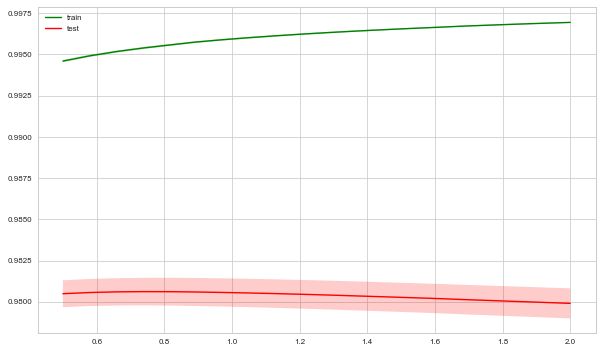

In [51]:
plt.figure(figsize=(10,6))
Cs_plot = [round(x,2) for x in Cs]
plot_validation_curves(Cs_plot, mean_scores_train, std_scores_train, mean_scores_val, std_scores_val)

Валидационная кривая:

Кривые валидации находятся близко друг другу и имеют высокое значение ROC-AUC в масштабах возможных изменений значений (0.5 - 1). Если бы значение ROC-AUC было бы довольно низкое, в то время как кривые находились бы рядом - это говорило бы о недообучении модели. При переобучении тренировочная и валидационная ошибки значительно бы отличались (не хватало бы регуляризации). В нашем случае при значении коэффициента регуляризации примерно равным 0.736842 модель показывает наилучшие результаты. При увеличении коэффициента (то есть снижении регуляризации, так как коэффициент равен 1/lambda) больше этого значения модель начинает переобучаться. При значениях коэффициента меньше этого значения (увеличение регуляризации) регуляризация избыточно сильная, модель недообучается.

Зафиксируем лучшее значение С в параметрах модели:

In [53]:
lr_params={'C': 0.73684,
           'solver': 'liblinear', 
           'penalty': 'l2',
           'class_weight': 'balanced',
           'random_state': 1,
           }
lr = LogisticRegression(**lr_params)

### Кривые обучения

С помощью кривых обучения можно проверить следующую гипотезу - действительно ли у нас достаточно данных. Можно ли улучшить качество модели, взяв больше данных? Это легко проверяется, если значение метрики на валидации сначала повышается и потом в какой-то момент выходит "на плато", то данных достаточно. Если же значение метрики даже при максимально доступном размере данных продолжает увеличиваться, то данных явно недостаточно для выявления закономерностей. В данном случае необходимо увеличить размер обучающей выборки, если это возможно.

Для построения кривых обучения используется ранее написанная функция multi_label_split. Минимальный размер выборки - 5% (примерно 5000 комментариев) от обучающей выборки, максимальный размер - вся обучающая выборка. На каждом проходе выборка разбивается на три фолда. таким образом, размер обучающей выборки определяется как произведение размера текущей выборки на 2/3. Также берется 18 промежуточных размеров. 

In [75]:
%%time
mean_scores_train=[]
std_scores_train=[]
mean_scores_val=[]
std_scores_val=[]
n_trains=[]
train_sizes = np.linspace(0.05, 1, 20)
n_train = len(y_train)*train_sizes

for num, size in enumerate(train_sizes):
    
    n_trains.append(int(n_train[num]))
    print('Размер выборки = {}'.format(int(n_trains[num]/3*2)))
    index_list, fold_dist = multi_label_split(y=y_train[:n_trains[num], :], folds=3)
    mean_score_tr, std_score_tr, mean_score_val, std_score_val = multi_label_cv(lr, train, y_train, 
                        index_list, tfidf_params=tfidf_params, X_f=feats_train, scale_cols=['length'], verbose=False)    
    mean_scores_train.append(mean_score_tr)
    std_scores_train.append(std_score_tr)
    mean_scores_val.append(mean_score_val)
    std_scores_val.append(std_score_val)

Размер выборки = 5318

MEAN ROC-AUС score: 0.978605

Размер выборки = 10638

MEAN ROC-AUС score: 0.981164

Размер выборки = 15956

MEAN ROC-AUС score: 0.981211

Размер выборки = 21276

MEAN ROC-AUС score: 0.981258

Размер выборки = 26594

MEAN ROC-AUС score: 0.981920

Размер выборки = 31914

MEAN ROC-AUС score: 0.982186

Размер выборки = 37232

MEAN ROC-AUС score: 0.981947

Размер выборки = 42552

MEAN ROC-AUС score: 0.982055

Размер выборки = 47870

MEAN ROC-AUС score: 0.981692

Размер выборки = 53190

MEAN ROC-AUС score: 0.981047

Размер выборки = 58509

MEAN ROC-AUС score: 0.981089

Размер выборки = 63828

MEAN ROC-AUС score: 0.980814

Размер выборки = 69147

MEAN ROC-AUС score: 0.980860

Размер выборки = 74466

MEAN ROC-AUС score: 0.980728

Размер выборки = 79785

MEAN ROC-AUС score: 0.981035

Размер выборки = 85104

MEAN ROC-AUС score: 0.980746

Размер выборки = 90423

MEAN ROC-AUС score: 0.980674

Размер выборки = 95742

MEAN ROC-AUС score: 0.980858

Размер выборки = 101061

MEAN

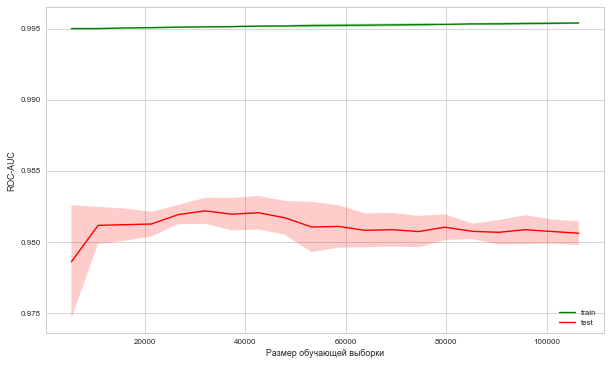

In [76]:
plt.figure(figsize=(10,6))
plot_learning_curve([int(x/3*2) for x in n_train.tolist()], mean_scores_train, std_scores_train, mean_scores_val, std_scores_val)

Видно, что в какой-то момент кривые сходятся и кривая валидации тестовой выборки выходит на плато. Данных явно достаточно для выявления закономерностей. Увеличение размера выборки не даст ощутимого прироста качества.

## Часть 11. Прогноз для тестовой выборки

Сделаем прогноз для тестовой выборки. Для этого загрузим образец файла для прогнозных значений и в соответствующем формате сохраним наши прогнозы. После этого загрузим файл с прогнозами на Kaggle. Результат на LB будет значением ROC-AUC для тестовой выборки. Для прогноза будем использовать гиперпараметры настроенные на кросс-валидации и такое же признаковое пространство.

In [77]:
submission = pd.read_csv('data/sample_submission.csv')
feats_test = pd.DataFrame()
feats_test['length'] = test['comment_text'].apply(len)
feats_test['upper_case_ratio'] = test['comment_text'].apply(lambda x: \
                                                            len(re.findall(r'[A-Z]',x))/(len(re.findall(r'[A-Za-z]',x))+1))
feats_test['exclamation_point'] = test['comment_text'].apply(lambda x: x.count('!')/len(x))
feats_test['asterix'] = test['comment_text'].apply(lambda x: 1 if x.count('*')>0 else 0)

In [80]:
tfidf_params={'ngram_range': (1,1),
              'max_features': 80000, 
              'stop_words': 'english',
              'sublinear_tf': True
                  }
lr_params={'C': 0.73684,
           'solver': 'liblinear', 
           'penalty': 'l2',
           'class_weight': 'balanced',
           'random_state': 1,
           }
lr = LogisticRegression(**lr_params)
cv = TfidfVectorizer(**tfidf_params)

X_train_csr = cv.fit_transform(train['comment_text'])
X_test_csr = cv.transform(test['comment_text'])  
        
scaler = StandardScaler()
feats_train['length'] = scaler.fit_transform(feats_train[['length']])
feats_test['length'] = scaler.transform(feats_test[['length']])
        
X_train = hstack([X_train_csr, feats_train.values])
X_test = hstack([X_test_csr, feats_test.values])

preds = np.zeros((test.shape[0], 6))
for i in range (6):
    lr.fit(X_train, y_train[:,i])
    preds[:,i] = lr.predict_proba(X_test)[:,1]

submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = preds
submission.to_csv('submission.csv', index=False)

Результат на LB:

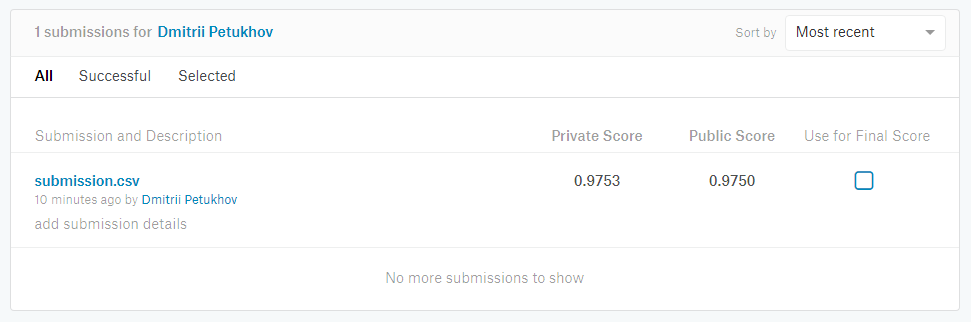

In [85]:
im = Image.open('data/place.png')
im

Получили довольно хороший результат, тем более для единственного прогноза в соревновании.
Также хорошо видно, что не произошло переобучения на Private Liderboard. В то же время значение ROC-AUC для тестовой выборки соотносится со значением на кросс-валидации. Можно сделать вывод о том, что модель имеет хорошее качество.

## Часть 12. Выводы

Построена модель, которая имеет хорошую обобщающую способность. Грамотно выбрана сама модель, проведена корректная кросс-валидация, на которой проверена значимость новых признаков и настроены гиперпараметры модели. Ценность модели заключается в том, что ее можно использовать для любого другого сервиса помимо Википедии. Автоматически модерировать нежелательные комментарии, что позволит улучшить качество общения пользователей и повысить конструктивность диалогов на образовательных сайтах.

В части путей улучшения, можно использовать следующие направления:

- Кластеризовать комментарии по языку.
- Добавить новые признаки.
- Использовать стемминг слов.
- Использовать лемматизацию слов.
- Добавить биграммы и триграммы.
- Добавить в список стоп-слов, слова характерные для платформы Википедия
- Использовать байесовский подход.
- Создать ансамбль моделей.

Задачи NLP хороши и интересны тем, что существует бесконечное множество путей, куда можно двигаться дальше, чтобы повысить качество решения задачи.